In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


F	January
G	February
H	March
J	April
K	May
M	June
N	July
Q	August
U	September
V	October
X	November
Z	December

In [238]:
list_of_markets=get_market_list()

# Testing loading data from Arctic database

In [239]:
df=pd.DataFrame()
for m in list_of_markets:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

RU
S


In [ ]:
ew_portfolio_pnl(pnl).cumsum().plot()

# Calculating portfolio diversification number

Calculate the achieved versus target volatility to create the scaling factor.  Since I'm targetting all markets to hit 100% volatility this number should be less than 1

$$ \sigma_{target} = \sqrt{w'\Sigma w} * ScalingFactor $$


$$  ScalingFactor=\frac{\sigma_{target}}{ \sqrt{w'\Sigma w}}  $$



In [ ]:
m=['A','M','C','L','P','TA','CF','V','FG']

In [ ]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))

In [ ]:
np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16

In [ ]:
ew_portfolio_pnl(pnl[m])['2012':].std()*16

In [ ]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))
vol_ach=np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16
vol_target=.15
portfolio_diversification= vol_target/vol_ach

In [ ]:
portfolio_diversification

# Function for getting the price for the most liquid contract


Use open interest to get the most active contract's price

In [30]:
mkts=get_market_list()

In [86]:
def _most_liquid_price(mkt):
    OI = load_market_open_interest(mkt).dropna(how='all')
    px= load_market_price(mkt).dropna(how='all')
    s=pd.Series()
    if px.size != 0:
        maxContract=OI.idxmax(axis=1)
        for row in maxContract.iteritems():
            s[row[0]]=px.ix[row[0]][row[1]]
    return s

In [93]:
def get_most_liquid_price(mkt):
    if type(mkt)==str:
        return _most_liquid_price(mkt)
    else:
        dic={}
        for m in mkt:
            dic[m]=get_most_liquid_price(m)
        return pd.DataFrame().from_dict(dic)

# Calculate Portfolio Weight

$$ \frac{1}{N}$$

In [132]:
pos=tsmom_daily(df[mkts],10)
pnl=calc_pnl_wc(pos,df[mkts])

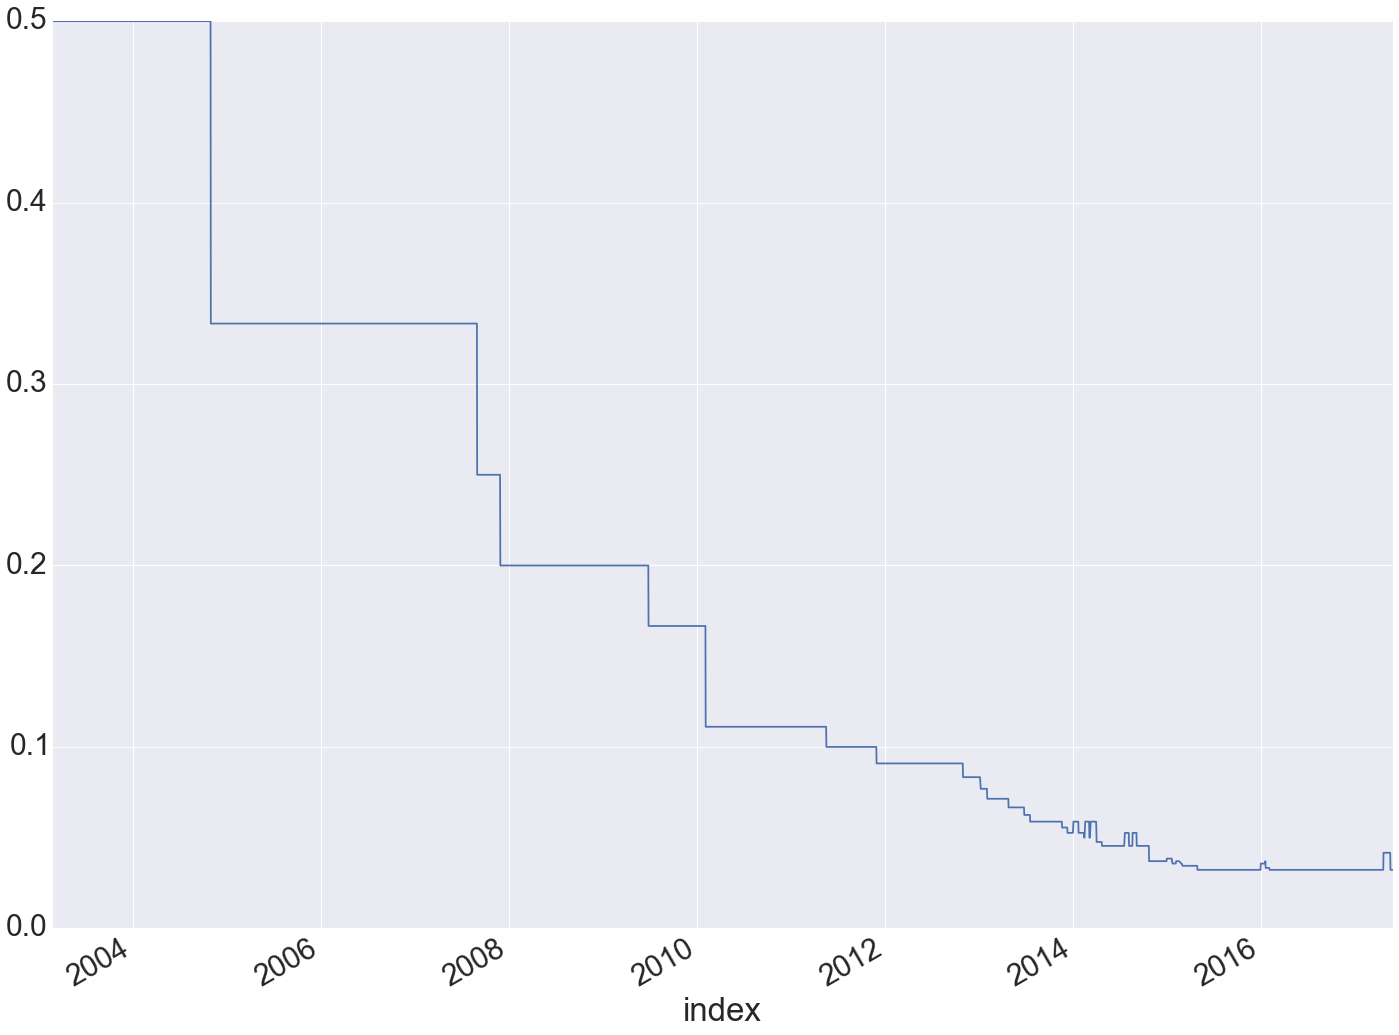

In [138]:
(1/pnl.dropna(how='all').count(axis=1)).plot()

# Calculate Notional Position

$$ Position_{m,t} = \frac{signal_{m,t} * scalingFactor_t * FundAUM_t * weight_{m,t} }{ContractSize_{m,t} } $$

Breaking out the scaling factor as something seems a bit off:

$$ Position_{m,t} = \frac{signal_{m,t} * \sigma_{target} * FundAUM_t * weight_{m,t} * DiversificationBenefit_t }{\sigma_{t}*ContractSize_{m,t} } $$

If you were just trading one market using risk scaling targetting a certain target
$$Position_{m,t} = \frac{\sigma_{target}*FundAUM_t  }{\sigma_t*contractSize_t} $$


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=50,adjust=True,com=50).std(bias=False)
  if __name__ == '__main__':


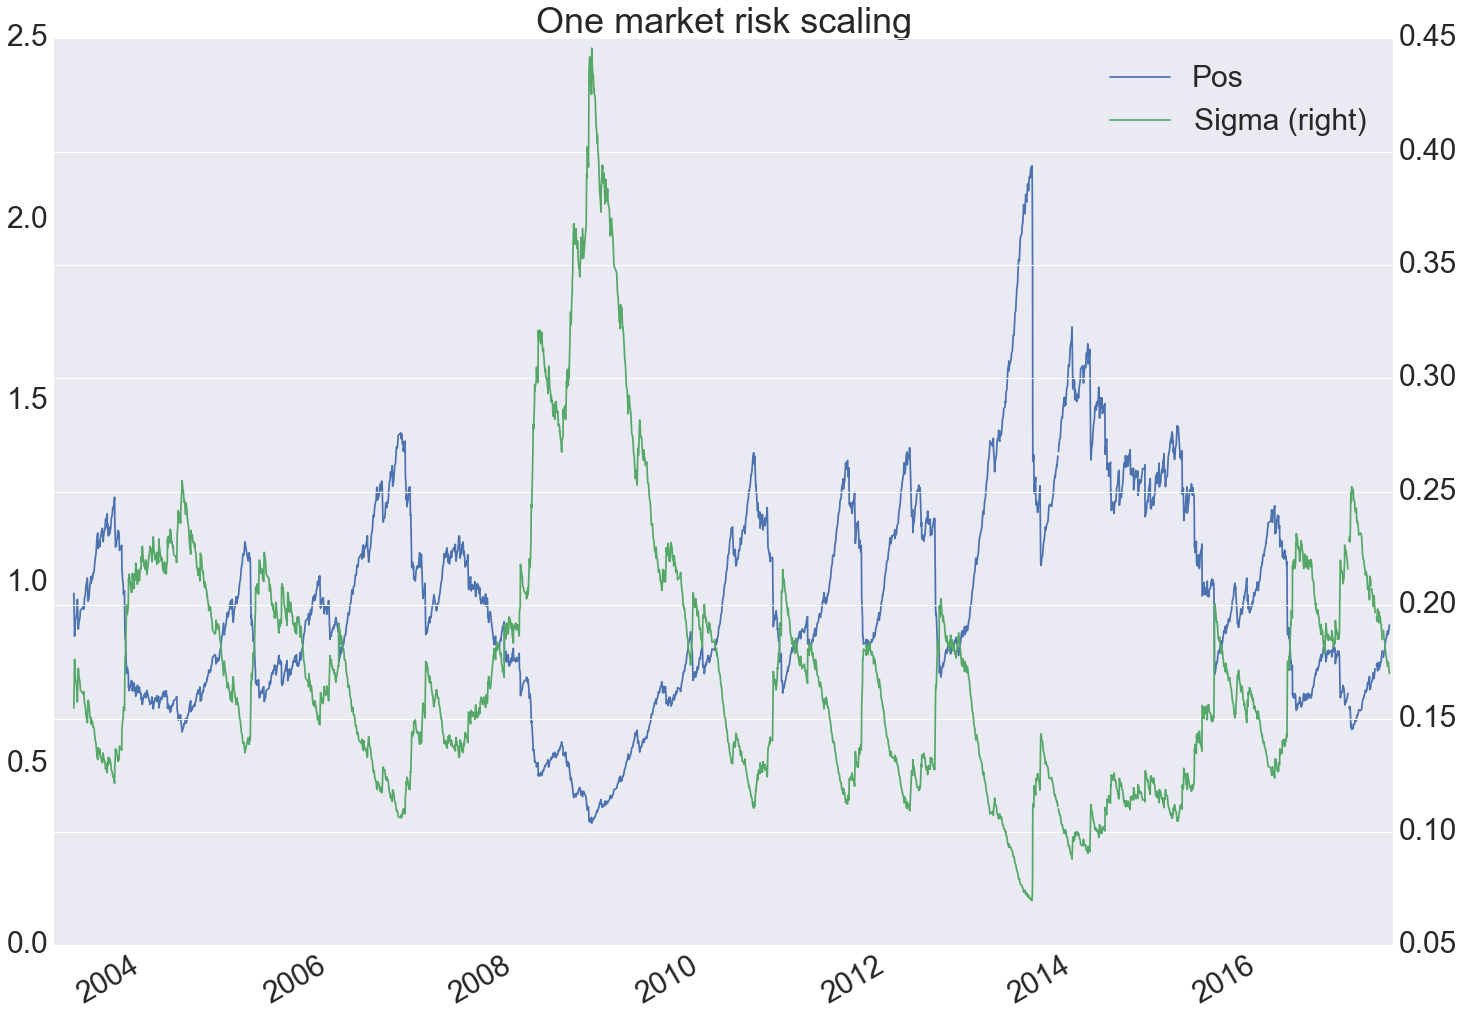

In [252]:
sig=pd.ewmstd(data.A,50,min_periods=50).dropna()*16
p=(.15*FundAUM)/(sig*curr_px.A)
temp =pd.DataFrame()
temp['Pos']=((p*curr_px.A)/FundAUM)
temp['Sigma']=sig
temp.plot(secondary_y='Sigma',title='One market risk scaling')

In [95]:
curr_px = get_most_liquid_price(mkts)

In [140]:
FundAUM = 1e6
w=(1/pnl.dropna(how='all').count(axis=1))

In [245]:
data=df[mkts]
vol_lookback=20
signal_lookback=250

mul=get_contract_multipliers()[data.columns]
vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
signal=pd.rolling_mean(data,signal_lookback)
signal = signal /abs(signal)
signal=(signal / (vol))


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()


In [248]:
dict={}
for m in signal.columns:
    dict[m]=(signal[m]*FundAUM*w*scaling_factor).dropna()

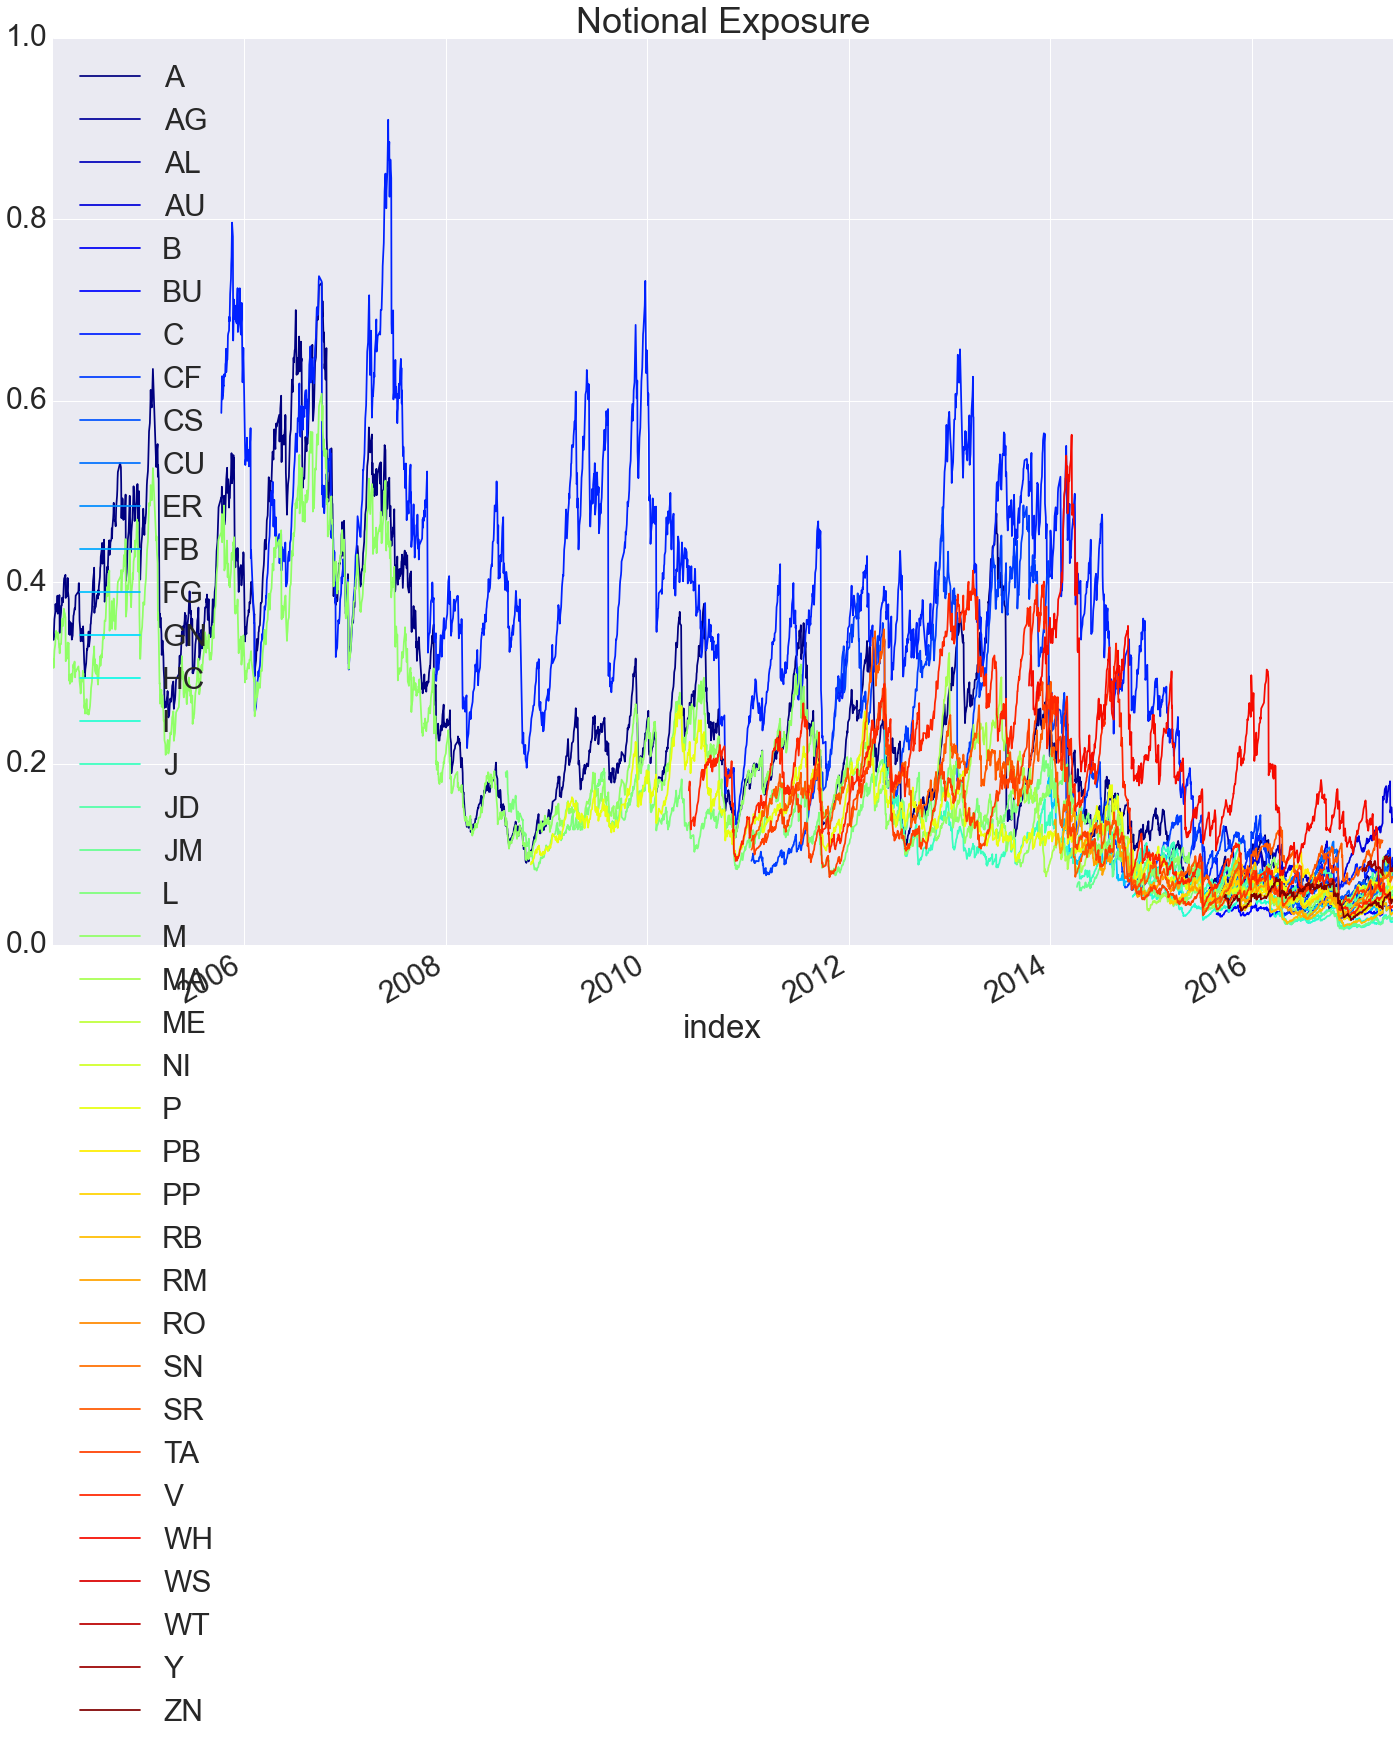

In [251]:
(pd.DataFrame().from_dict(dict).abs()/FundAUM).plot(colormap='jet',title='Notional Exposure')

# Calculate rounded lots

In [263]:
dict={}
for m in signal.columns:
    dict[m]=(signal[m]*FundAUM*w*scaling_factor)/(curr_px[m]*mul[m]).dropna()
    

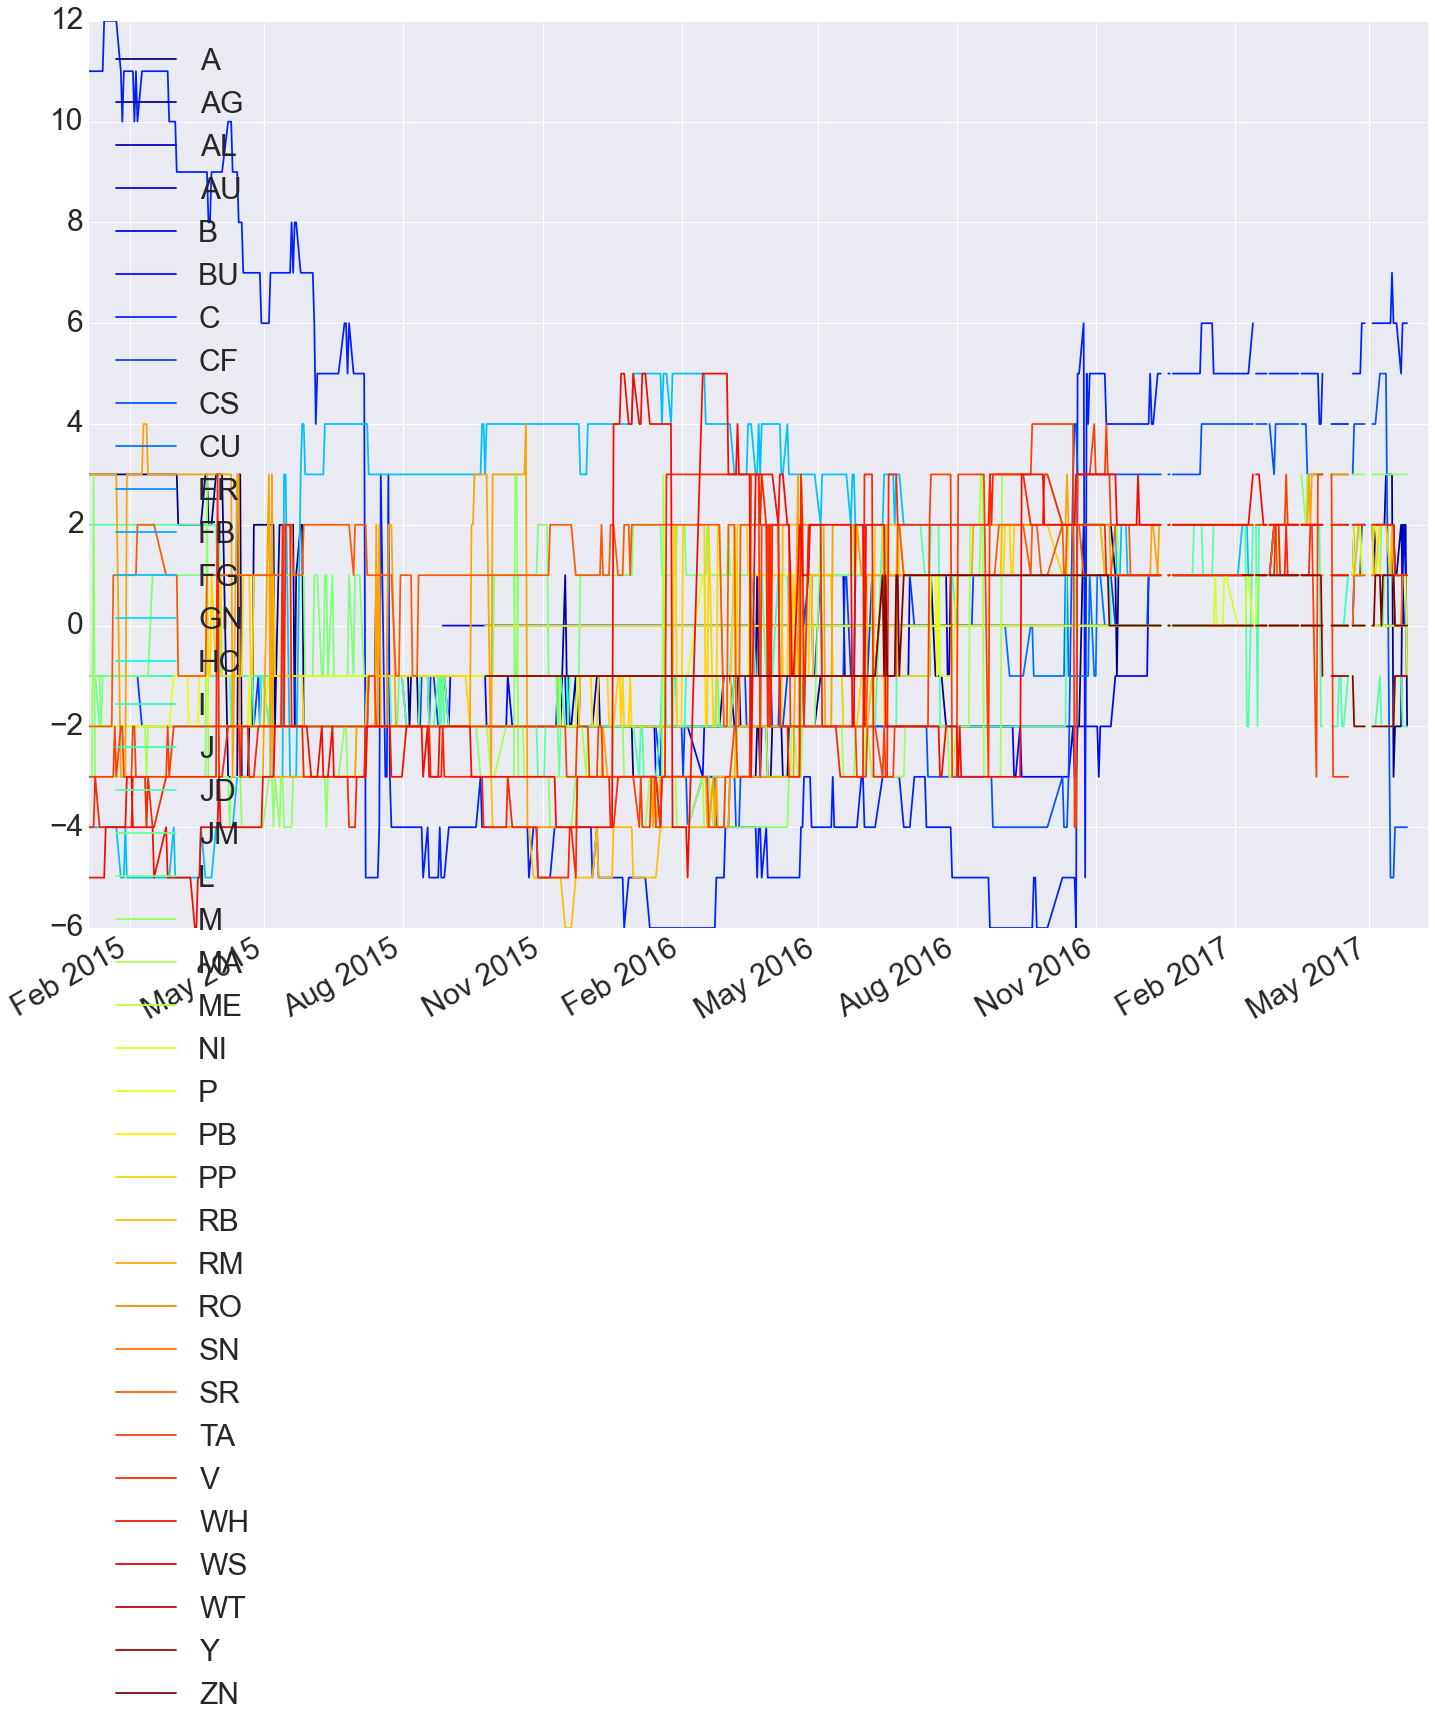

In [273]:
pd.DataFrame().from_dict(dict).round()['2015':].plot(colormap='jet')